# Functional connectome similarity within families (2021)

### (C) Philip Brandner, September 2021

This notebook is the entire analysis pipeline for the Paper on Family functional connectome similarity.

See Nilearn Tutorial for resting-state: https://nilearn.github.io/connectivity/index.html


# Outline



___

# Processing Decisions

### Slice-Timing

This is a limitation of the DICOM files created by Philips 1. I would suggest you lobby your Philips Research Collaboration Manager to have this information stored in the DICOM files for future Philips software versions. In the mean time, you will need to BIDS SliceTiming field yourself. You will need to know:

- Repetition Time (time between start of one volume and start of the next) (BIDS RepetitionTime and NIfTI pixdim[4]).
- Delay Between Volumes (is there a temporal gap between the acquisition of the last slice of one volume and the first slice of the next).
- Number of Slices (NIfTI dim[3])
- Multiband factor
- Ascending or descending slice order
- Sequential of interleaved slice order.

see: https://neurostars.org/t/warning-1-code-13-slice-timing-not-defined/5273/2

see also: https://fmriprep.org/en/stable/workflows.html?highlight=slicetiming#slice-time-correction

See SPM Wiki: https://en.wikibooks.org/wiki/SPM/Slice_Timing#Multiband_EPI_acquisitions

**Maybe SliceTiming correction is not necessary with MULTIBAND becaus of such a short TR?**

With very small TRs such as multiband, it becomes very complicated to slice time correct because there are usually a high number of slices and any slight movement might make slice time correction to correct the wrong slice, and this correction is less necessary as the TR is small and the temporal difference between slices is thus reduced. In such cases, you can choose to skip slice timing correction (or use a temporal derivative, which can account for +/- 1 second of changes in timing[5]).

However, it was shown that slice timing correction is always beneficial, even for fast TR < 2s such as obtained with multiband[2]. Indeed, it was observed that slice timing correction helps more with the slices that are more delayed (ie, towards the end of the slice order) and that slice timing correction increases the statistical effect size the longer the TR, with diminishing returns as the TR is shorter, down to 0.5s where the common methods of slice timing correction do not help anymore[32]. However, with new slice timing correction methods such as upsampling and lowpass filtering, there is still a significant gain, that is constant whatever the TR[32].

Paper: https://www.frontiersin.org/articles/10.3389/fnins.2019.00821/full

fMRIprep uses AFNI's 3dTshift algorithm. Does it make sense to use it with that?
see: https://afni.nimh.nih.gov/pub/dist/doc/program_help/3dTshift.html

"We have successfully analyzed multiband data for various tasks using FMRIPREP with similar settings and using similar confound regressors on first level. The only exception is that we used **--ignore slicetiming** option."
see: https://neurostars.org/t/fmriprep-advices-for-multiband/747

### CONCLUSION: Don't use STC in fmriprep

### Parcellation choice

see Schaefer et al. 2018:http://people.csail.mit.edu/ythomas/publications/2018LocalGlobal-CerebCor.pdf

github: https://github.com/ThomasYeoLab/CBIG/tree/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal


### Yeo's networks 7

![alt text](https://github.com/ThomasYeoLab/CBIG/raw/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/readme_figures/Schaefer2018_400parcel_parcellation_match_Yeo_7_network_fslr32k.png "Title")




#### Question: How many parcels to choose from the Schaefer template? (100-1000)

- 400 Parcels, seems a reasonable standard number for whole cortex (bilateral)
- Why not the highest number of parcels (1000)? Don't forget with ICA-AROMA we get 6mm smoothing built in!


#### Question: Which space should i do all my analysis (fsaverage - more appropriate for FC, MNI)?

- d


### ICA-AROMA

https://github.com/nipreps/fmriprep/issues/1799

https://neurostars.org/t/fmriprep-ica-aroma-filtering-including-wm-csf-etc-confounds-in-fsl-regfilt/3137
also: https://github.com/nipreps/fmriprep/issues/817

notebook examples:
- https://github.com/nipreps/fmriprep-notebooks/blob/9933a628dfb759dc73e61701c144d67898b92de0/05%20-%20Discussion%20AROMA%20confounds%20-%20issue-817%20%5BJ.%20Kent%5D.ipynb
- https://github.com/oesteban/aroma-chris-notebook/blob/master/Denoising%2Bthe%2Bdenoising.ipynb


#### fMRIprep
**For datasets with a very short TR and a large number of timepoints, this may result in an unusually high number of components. By default, dimensionality is limited to a maximum of 200 components.** 

To override this upper limit one may specify the number of components to be extracted with **--aroma-melodic-dimensionality**. Further details on the implementation are given within the workflow generation function (init_ica_aroma_wf()).


- set --aroma-melodic-dimensionality to 50 (currently our subjects get >130)


Note: non-aggressive AROMA denoising is a fundamentally different procedure from its “aggressive” counterpart and cannot be performed only by using a set of noise regressors (a separate GLM with both noise and signal regressors needs to be used). Therefore instead of regressors, fMRIPrep produces non-aggressive denoised 4D NIFTI files in the MNI space:

*space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz


#### Isssue #1 ICA-AROMA is in MNI152 space, what about the parcellation method I want to use local/global?

Looks like Schaefers parcellations come in MNI space. should be fine! It works!

![title](/Users/philipb/surfdrive/PhD/BRAINLINKS/T1_Ouderstudie/images/fmriprep_ica_aroma.jpg)

If you are already using AROMA-cleaned data (~desc-smoothAROMAnonaggr_bold.nii.gz), do not include ICA-AROMA confounds during your design specification or denoising procedure.

Additionally, as per [Hallquist2013] and [Lindquist2019], when using AROMA-cleaned data most of the confound regressors should be recalculated (this feature is a work-in-progress, follow up on #1905). Surprisingly, our simulations (with thanks to JD. Kent) suggest that using the confounds as currently calculated by fMRIPrep –before denoising– would be just fine.

see: https://fmriprep.org/en/stable/outputs.html#derivatives-of-fmriprep-preprocessed-data

### aCompCor

*Opinions on this topic are divided and this is why FMRIPREP provides those regressors instead of cleaning up the data for you. I personally would include 6 motion parameters, FD, and aCompCor on run level and mean FD on group level (for both task and rest).*

Chris Gor. (https://neurostars.org/t/confounds-from-fmriprep-which-one-would-you-use-for-glm/326)

- Best Practices aCompCor: https://neurostars.org/t/best-practices-for-aroma-and-fmriprep/1619

## Low-bandpass Filtering

see: https://carpentries-incubator.github.io/SDC-BIDS-fMRI/05-data-cleaning-with-nilearn/index.html

##  How to vectorize connectome matrix

Should be pretty straightforward with nilearn: https://nilearn.github.io/modules/generated/nilearn.connectome.ConnectivityMeasure.html

- nilearn.connectome.ConnectivityMeasure

has a vectorize boolean, that converts the matrix into a 1D vector.

- Play around with that and do some initial correlations.

## START HERE: Nilearn Tutorials


- GENERAL NILEARN 101: https://carpentries-incubator.github.io/SDC-BIDS-fMRI/

- Specific Nilearn tutorial: https://nilearn.github.io/auto_examples/03_connectivity/plot_group_level_connectivity.html



___

# 0) Tutorial: Nilearn basic functions

Nilearn can fetch many different atlases, including the one we'll be using (Schaefer et al. 2018).
- 400 parcels
- 7 networks (yeo et al. 2011)
- resolution 2mm


In [11]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from bids import BIDSLayout,layout
import nibabel as nib
from nilearn import datasets
from nilearn import plotting as plot
from nilearn import image as img
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

import matplotlib.pyplot as plt

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline

In [6]:
import nilearn
nilearn.__version__

'0.8.0'

### How to install packages
- https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/

In [9]:
 # Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install pybids

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3 -m pip install --upgrade pip' command.


### Create base directory paths

In [12]:
# Let's get data from one subject

T1w = layout.get(subject='BL122',datatype='anat')
brainmask = layout.get(subject='BL122',datatype='anat',suffix='brainmask')
func_files = layout.get(subject='BL122',datatype='func')

AttributeError: module 'bids.layout' has no attribute 'get'

In [8]:
# T1_mni = T1w[27].path
# T1_mni_img = img.load_img(T1_mni)
# print('Dimensions T1: ',T1_mni_img.shape)

# Tell Nilearn which of the functional images in the func folder to use
func_mni = func_files[9].path

# Use img.load_img to load the functional image
func_mni_img = img.load_img(func_mni)

# Show the 4-dimensional shape of the Nifti file
print('Dimensions FUNC: ',func_mni_img.shape)

# Let us look at one volume (TR index) of the 4D Nifti file
func_10 = func_mni_img.slicer[:,:,:,8]
plot.plot_epi(func_10)

NameError: name 'func_files' is not defined

In [ ]:
# Let's look at the actual time-series data of this functional image
#Pick one voxel at coordinate (60,45,88)

single_voxel = func_mni_img.slicer[59:60,45:46,30:31,:].get_data()
# Now we see that we have 1 voxel but the entire time-series of 450 volumes
print('Dimensions Single VOXEL time series: ',single_voxel.shape)

# We don't need the 3-dimensions anymore if we just want to look at 1 voxel
single_voxel = single_voxel.flatten()
print(single_voxel.shape)

# Let's visualize the timeseries using matplotlib

# Make an array
x_axis = np.arange(0,single_voxel.shape[0])

# specify x and y data
plt.plot(x_axis,single_voxel,'b')

# label our axis
plt.xlabel('Timepoint')
plt.ylabel('Signal Value')

# Themes, Color, Presets

In [4]:
from matplotlib.colors import LinearSegmentedColormap

within_color = '#6F8ABF'
family_color = '#6CBFCC'
family_parent_child_color = '#6DE3D2'
family_parent_parent_color = '#6CBFCC'

child_child_color = '#F2BB16'
child_adult_color = '#F2A81D'
adult_adult_color = '#F2994B'

cmap = LinearSegmentedColormap.from_list('RedGreenRed', ['#6F8ABF','#6CBFCC', '#FFFFFF', '#F2BB16','#A64D2D'])

# Set the font and figure settings in seaborn
# see: http://seaborn.pydata.org/tutorial/aesthetics.html

sns.set(font_scale = 2)
sns.set_style("ticks")


___

# 1) Import subjects & basic setup

## 1.1) Define Schaefer - 100 ROI atlas

dict_keys(['maps', 'labels', 'description'])


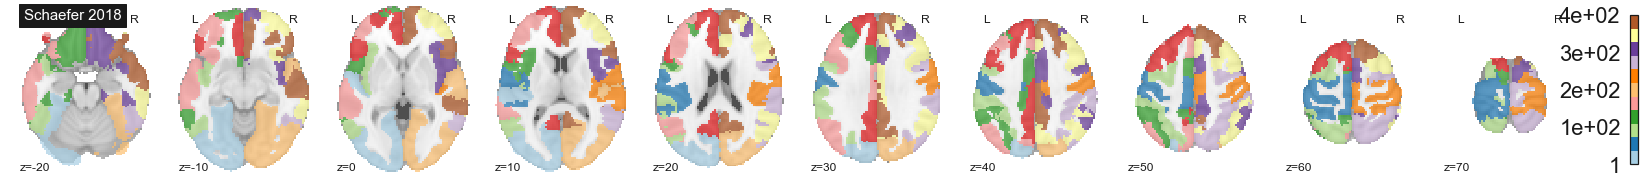

In [5]:
# First we need to fetch the Schaefer 2018 atlas and store it in a variable for atlas_filename & labels
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=7, resolution_mm=2, data_dir=None, base_url=None, resume=True, verbose=1)
atlas_filename = atlas.maps
labels = atlas.labels

print(atlas.keys())
# plotting.plot_roi(atlas_filename,title="Schaefer 2018",view_type = "continuous")
plot.plot_roi(atlas_filename,
                  cut_coords=(-20,-10,0,10,20,30,40,50,60,70),
                  display_mode='z',
                  colorbar=True,
                  cmap='Paired',
                  title='Schaefer 2018')

In [20]:
#Base directory from fMRIprep output
fmriprep_dir = '/Users/philipb/owncloud/2018_Brainlinks (Projectfolder)/Brainlinks_Parentstudy/Brainlinks_Parentstudy_Analyses/functional_connectome/fmriprep_final'
layout = BIDSLayout(fmriprep_dir,validate=False)

# Show the subjects of your BIDS dir
layout.get_subjects()

#layout.get_tasks()

['BL065',
 'BL067',
 'BL073',
 'BL076',
 'BL077',
 'BL081',
 'BL082',
 'BL084',
 'BL086',
 'BL087',
 'BL088',
 'BL089',
 'BL090',
 'BL092',
 'BL096',
 'BL102',
 'BL104',
 'BL111',
 'BL113',
 'BL114',
 'BL115',
 'BL117',
 'BL122',
 'BL127',
 'BL131',
 'BL134',
 'BL135',
 'BL138',
 'BL140',
 'BL142',
 'BL143',
 'BL154',
 'BL155',
 'BL156',
 'BL160',
 'BL161',
 'BL163',
 'BL169',
 'BL177',
 'BL182',
 'BL185',
 'BL188',
 'BL192',
 'BL198',
 'BL203',
 'BL206',
 'BL209',
 'BL210',
 'BL212',
 'BL214',
 'BL217',
 'BL0651',
 'BL0652',
 'BL0671',
 'BL0731',
 'BL0761',
 'BL0771',
 'BL0772',
 'BL0812',
 'BL0821',
 'BL0822',
 'BL0841',
 'BL0862',
 'BL0871',
 'BL0881',
 'BL0882',
 'BL0891',
 'BL0901',
 'BL0921',
 'BL0922',
 'BL0961',
 'BL1022',
 'BL1041',
 'BL1111',
 'BL1112',
 'BL1131',
 'BL1141',
 'BL1142',
 'BL1151',
 'BL1171',
 'BL1172',
 'BL1221',
 'BL1222',
 'BL1272',
 'BL1311',
 'BL1312',
 'BL1341',
 'BL1351',
 'BL1352',
 'BL1381',
 'BL1382',
 'BL1401',
 'BL1422',
 'BL1431',
 'BL1432',
 'BL15

___

# 2) Extract time series & process data

For input and output see: https://nilearn.github.io/manipulating_images/input_output.html

In [21]:
# Create subject list that takes sessions into account
# see: https://bids-standard.github.io/pybids/layout/index.html

# 1) Read the BIDS dataset and check the number of sessions that person has
subjects_session_list = []
subject_sessions = []
subjects = layout.get_subjects()

# 2) Preprocessing exclusion list
preprocessing_exclusion_list = ['BL114']

for excluded in preprocessing_exclusion_list:
    if excluded in subjects: subjects.remove(excluded)

for sub in subjects:
    subject_sessions = layout.get_sessions(subject=sub,task="rest")
    subject_sessions_length = len(subject_sessions)
    print(sub,subject_sessions)
    print('Length of list: ',len(subject_sessions))
    subject_list_name1 = sub + '-1'
    subject_list_name2 = sub + '-2'
    if subject_sessions_length == 2:
        subjects_session_list.append(subject_list_name1)
        subjects_session_list.append(subject_list_name2)
    else:
        subjects_session_list.append(subject_list_name1)
print(subjects_session_list)

BL065 ['01', '02']
Length of list:  2
BL067 ['01', '02']
Length of list:  2
BL073 ['01']
Length of list:  1
BL076 ['01']
Length of list:  1
BL077 ['01', '02']
Length of list:  2
BL081 ['01', '02']
Length of list:  2
BL082 ['01', '02']
Length of list:  2
BL084 ['01', '02']
Length of list:  2
BL086 ['01', '02']
Length of list:  2
BL087 ['01', '02']
Length of list:  2
BL088 ['01', '02']
Length of list:  2
BL089 ['01', '02']
Length of list:  2
BL090 ['01']
Length of list:  1
BL092 ['01', '02']
Length of list:  2
BL096 ['01', '02']
Length of list:  2
BL102 ['01', '02']
Length of list:  2
BL104 ['01']
Length of list:  1
BL111 ['01', '02']
Length of list:  2
BL113 ['01', '02']
Length of list:  2
BL115 ['01']
Length of list:  1
BL117 ['01', '02']
Length of list:  2
BL122 ['01', '02']
Length of list:  2
BL127 ['01', '02']
Length of list:  2
BL131 ['01', '02']
Length of list:  2
BL134 ['01', '02']
Length of list:  2
BL135 ['01', '02']
Length of list:  2
BL138 ['01', '02']
Length of list:  2
BL14

## 2.1) Create correlation matrices after denoising, detrending, smoothing

In [57]:
#Set denoising constants
print(len(subjects),' Subjects in total')
sessions = layout.get_session()
confound_vars = ['trans_x','trans_y','trans_z','rot_x','rot_y','rot_z','global_signal','a_comp_cor_00','a_comp_cor_01','a_comp_cor_02','a_comp_cor_03','a_comp_cor_04','a_comp_cor_05']
high_pass= 0.009
low_pass = 0.08
TR=0.69
prefix='sub-'
prefix_ses='ses-'
sessions = ['ses-01','ses-02']

# Allowed connectivity kinds are "correlation", "partial correlation", 
#"tangent", "covariance" and "precision", got kind "full correlation"
correlation_type = 'partial correlation'
subjects_timeseries = []
all_connectomes = []
empty_subjects = []
print('-------------- Empty All connectome list -----------')
print(all_connectomes)

# let's loop through all subjects and create correlation matrices    
for sub in subjects:
    
    # Get functional images
    for ses in sessions:
        print('------------------------------------ Subject: ' + sub + ' session: ' + ses + ' -----------------------------------------')

        try:
            func_file = os.path.join(fmriprep_dir,prefix+sub,ses,'func',prefix+sub+'_'+ses+'_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
            # LOAD IMAGE 
            func_img = img.load_img(func_file)
            func_file_missing = False
        except:
            func_file_missing = True
            print('No functional file for subject: ',sub)
            if ses == 'ses-01':
                empty_subject_name = sub + '-1'
            elif ses == 'ses-02':
                empty_subject_name = sub + '-2'
            empty_subjects.append(empty_subject_name)

        # Get confounds
        try:
            confound_file = os.path.join(fmriprep_dir,prefix+sub,ses,'func',prefix+sub+'_'+ses+'_task-rest_desc-confounds_timeseries.tsv')
            confound_df = pd.read_csv(confound_file,delimiter='\t')
            confounds = confound_df[confound_vars]
        except:
            print('No confound file for subject: ',sub)


        # The input_data.NiftiLabelsMasker object is a wrapper that applies parcellation, cleaning and averaging to an functional image
        masker = NiftiLabelsMasker(labels_img=atlas_filename,
                                   standardize=True, # the signal is z-scored to the mean (important for later vectorizing)
                                   verbose=0,
                                   memory='nilearn_cache',
                                   detrend=True,
                                   smoothing_fwhm=6,
                                   low_pass=low_pass,
                                   high_pass=high_pass,
                                   t_r=TR)

        #time_series = masker.fit_transform(result_image,confounds=confounds)
        if func_file_missing == False:
            time_series = masker.fit_transform(func_img,confounds)
            subjects_timeseries.append(time_series)
            
            # Compute vectorized 1D matrix for comparison & save to subject directory
            connectivity = ConnectivityMeasure(kind=correlation_type,vectorize=True,discard_diagonal=True)
            connectome_1d = connectivity.fit_transform([time_series])

            # Combine all vectorized 1D arrays into a larger array Subjects 
            # THIS IS USED FOR FURTHER ANALYSIS because it is VECTORIZED
            all_connectomes.append(connectome_1d)
        else:
            continue
            

# Compute connectivity matrix from time_series
# THIS IS USED FOR Functional connectome Visualization
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform(subjects_timeseries)
print('--------- Subjects time series SHAPE -----------')
print(correlation_matrix.shape)

    
# Combine all connectomes into 1 big numpy array
# see: https://stackoverflow.com/questions/58083743/what-is-the-fastest-way-to-stack-numpy-arrays-in-a-loop

all_connectome_final = np.concatenate(all_connectomes,axis=0)
all_connectome_final = np.transpose(all_connectome_final)

family_classifier = all_connectome_final
family_classifier.to_csv("ML_connectome_classifier.csv")

print('---------------- ALL CONNECTOMES POST LOOP ------------')
print(all_connectome_final)
    
## Numpy's array into pandas table with subject headers
# First remove empty subjects from subject_list

for empty in empty_subjects:
    if empty in subjects_session_list: subjects_session_list.remove(empty)

print('----- Empty subjects list ---------')
print(empty_subjects)
print('----- Adjusted subjects list ---------')
print(subjects_session_list)

subjects_connectomes_all = pd.DataFrame(data=all_connectome_final,columns=subjects_session_list)
print(subjects_connectomes_all)
subjects_connectomes_all.to_csv("connectomes_all.csv")

# Here we calculate the subject to subject correlation matrix for their vectorized within subject connectivity matrix
subjects_connectome_correlation_matrix = subjects_connectomes_all.corr().abs()
print(subjects_connectome_correlation_matrix)
subjects_connectome_correlation_matrix.to_csv("/Users/philipb/owncloud/2018_Brainlinks (Projectfolder)/Brainlinks_Parentstudy/Brainlinks_Parentstudy_Analyses/functional_connectome/fmriprep_final/1_subjects_connectome_correlation_matrix.csv")

126  Subjects in total
-------------- Empty All connectome list -----------
[]
------------------------------------ Subject: BL065 session: ses-01 -----------------------------------------
------------------------------------ Subject: BL065 session: ses-02 -----------------------------------------
------------------------------------ Subject: BL067 session: ses-01 -----------------------------------------
------------------------------------ Subject: BL067 session: ses-02 -----------------------------------------
------------------------------------ Subject: BL073 session: ses-01 -----------------------------------------
------------------------------------ Subject: BL073 session: ses-02 -----------------------------------------
No functional file for subject:  BL073
No confound file for subject:  BL073
------------------------------------ Subject: BL076 session: ses-01 -----------------------------------------
------------------------------------ Subject: BL076 session: ses-02 -------

------------------------------------ Subject: BL163 session: ses-02 -----------------------------------------
------------------------------------ Subject: BL169 session: ses-01 -----------------------------------------
------------------------------------ Subject: BL169 session: ses-02 -----------------------------------------
------------------------------------ Subject: BL177 session: ses-01 -----------------------------------------
------------------------------------ Subject: BL177 session: ses-02 -----------------------------------------
------------------------------------ Subject: BL182 session: ses-01 -----------------------------------------
------------------------------------ Subject: BL182 session: ses-02 -----------------------------------------
------------------------------------ Subject: BL185 session: ses-01 -----------------------------------------
------------------------------------ Subject: BL185 session: ses-02 -----------------------------------------
----------

------------------------------------ Subject: BL0901 session: ses-02 -----------------------------------------
No functional file for subject:  BL0901
No confound file for subject:  BL0901
------------------------------------ Subject: BL0921 session: ses-01 -----------------------------------------
------------------------------------ Subject: BL0921 session: ses-02 -----------------------------------------
No functional file for subject:  BL0921
No confound file for subject:  BL0921
------------------------------------ Subject: BL0922 session: ses-01 -----------------------------------------
------------------------------------ Subject: BL0922 session: ses-02 -----------------------------------------
No functional file for subject:  BL0922
No confound file for subject:  BL0922
------------------------------------ Subject: BL0961 session: ses-01 -----------------------------------------
------------------------------------ Subject: BL0961 session: ses-02 -------------------------------

------------------------------------ Subject: BL1541 session: ses-02 -----------------------------------------
No functional file for subject:  BL1541
No confound file for subject:  BL1541
------------------------------------ Subject: BL1542 session: ses-01 -----------------------------------------
------------------------------------ Subject: BL1542 session: ses-02 -----------------------------------------
No functional file for subject:  BL1542
No confound file for subject:  BL1542
------------------------------------ Subject: BL1551 session: ses-01 -----------------------------------------
------------------------------------ Subject: BL1551 session: ses-02 -----------------------------------------
No functional file for subject:  BL1551
No confound file for subject:  BL1551
------------------------------------ Subject: BL1561 session: ses-01 -----------------------------------------
------------------------------------ Subject: BL1561 session: ses-02 -------------------------------

------------------------------------ Subject: BL2121 session: ses-02 -----------------------------------------
No functional file for subject:  BL2121
No confound file for subject:  BL2121
------------------------------------ Subject: BL2141 session: ses-01 -----------------------------------------
------------------------------------ Subject: BL2141 session: ses-02 -----------------------------------------
No functional file for subject:  BL2141
No confound file for subject:  BL2141
------------------------------------ Subject: BL2171 session: ses-01 -----------------------------------------
------------------------------------ Subject: BL2171 session: ses-02 -----------------------------------------
No functional file for subject:  BL2171
No confound file for subject:  BL2171
------------------------------------ Subject: BL2172 session: ses-01 -----------------------------------------
------------------------------------ Subject: BL2172 session: ses-02 -------------------------------

AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'

In [ ]:
# Let's create a connectome correlation matrix with only ses-1 connectomes (no ses-2)
# We will need this for the Finn et al. replication with family identification

subjects_connectomes_all_no_ses_2 = subjects_connectomes_all.loc[:, ~subjects_connectomes_all.columns.str.contains('-2$')]
subjects_connectome_correlation_matrix_no_ses_2 = subjects_connectomes_all_no_ses_2.corr()
subjects_connectome_correlation_matrix_no_ses_2.values[[np.arange(subjects_connectome_correlation_matrix_no_ses_2.shape[0])]*2] = 0
subjects_connectome_correlation_matrix_no_ses_2.head()

In [ ]:
all_connectome_final.shape

In [28]:
correlation_matrix.shape

(168, 400, 400)

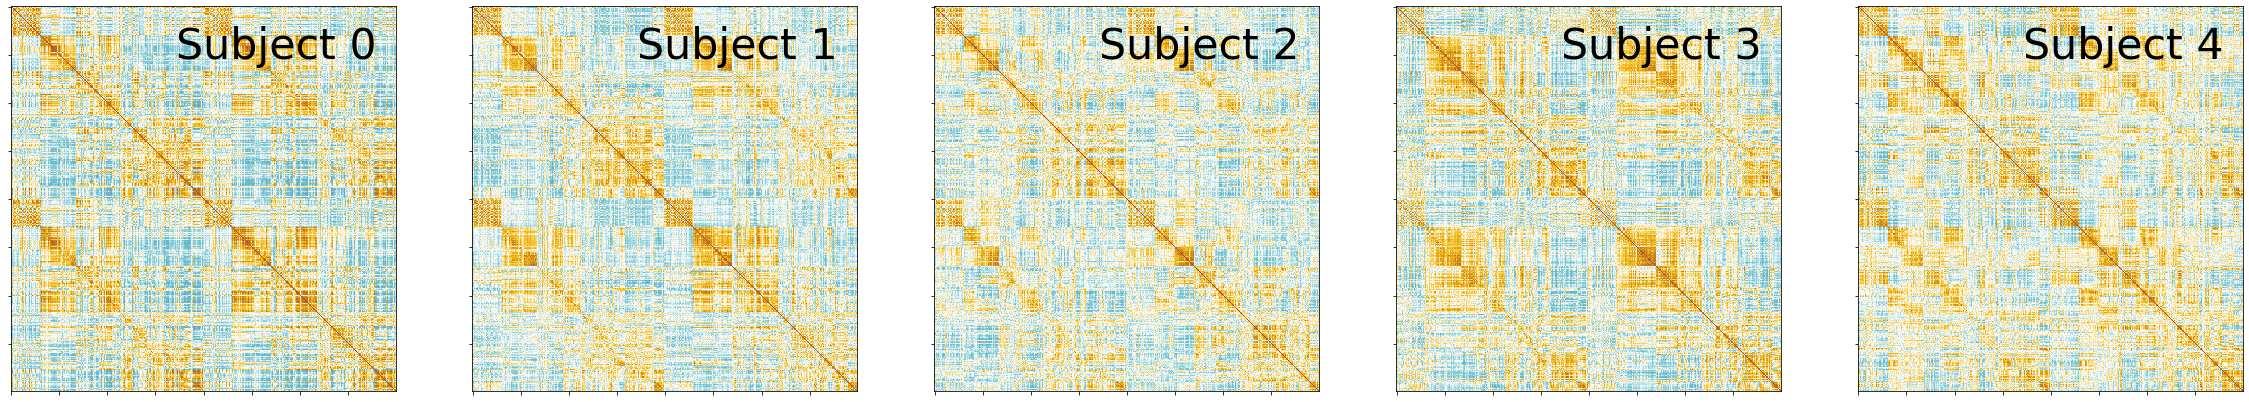

In [14]:
from nilearn import plotting
from matplotlib import pyplot as plt

_, axes = plt.subplots(1, 5, figsize=(40, 20))
for i, (matrix, ax) in enumerate(zip(correlation_matrix, axes)):
    plotting.plot_matrix(matrix, tri='full',colorbar=False, axes=ax,
                         title='Subject {}'.format(i),
                        vmin=-1,vmax=1,cmap=cmap)

RESULTS/Figures/matrices_all/functional_connectome_1.png


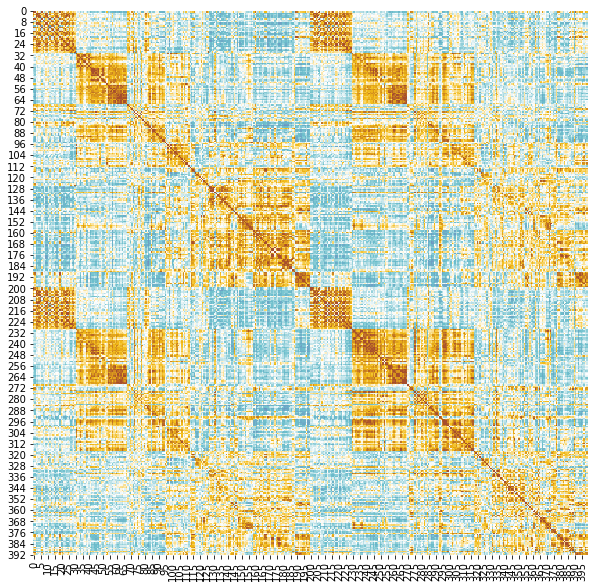

In [64]:
# https://seaborn.pydata.org/generated/seaborn.heatmap.html?highlight=heatmap#seaborn.heatmap
plt.figure(figsize=(15,10))

for i in range(1,2):
    sns.heatmap(correlation_matrix[i],cmap=cmap,square=True,robust=False,cbar=False,
                vmin=-0.8,vmax=0.8,center=0)
    figure_name = 'RESULTS/Figures/matrices_all/functional_connectome_' + str(i) + '.png'
    print(figure_name)
    plt.savefig(figure_name, dpi = 150)

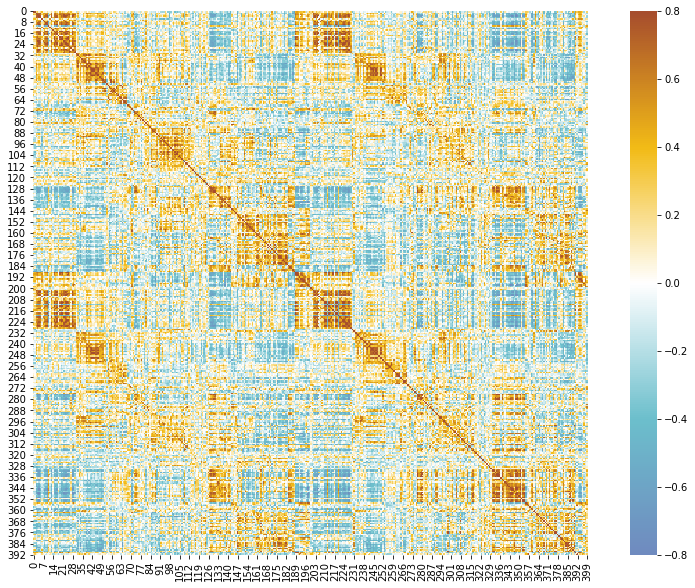

In [106]:
# https://seaborn.pydata.org/generated/seaborn.heatmap.html?highlight=heatmap#seaborn.heatmap
plt.figure(figsize=(15,10))

sns.heatmap(correlation_matrix[70],cmap=cmap,square=True,robust=False,cbar=True,
            vmin=-0.8,vmax=0.8,center=0)

## 2.2) Mean group level connectivity matrix

https://nilearn.github.io/auto_examples/03_connectivity/plot_group_level_connectivity.html

In [15]:
children_timeseries = subjects_timeseries[0:91]
adult_timeseries = subjects_timeseries[92:168]

In [16]:
# First we need to create correlation measures and fir the matrices to the timeseries

# FOR CHILDREN
correlation_measures_children = ConnectivityMeasure(kind='correlation')
correlation_matrices_children = correlation_measures_children.fit_transform(children_timeseries)

# FOR ADULTS
correlation_measures_adults = ConnectivityMeasure(kind='correlation')
correlation_matrices_adults = correlation_measures_adults.fit_transform(adult_timeseries)

mean_connectivity_matrix_children = correlation_measures_children.mean_
mean_connectivity_matrix_adults = correlation_measures_adults.mean_


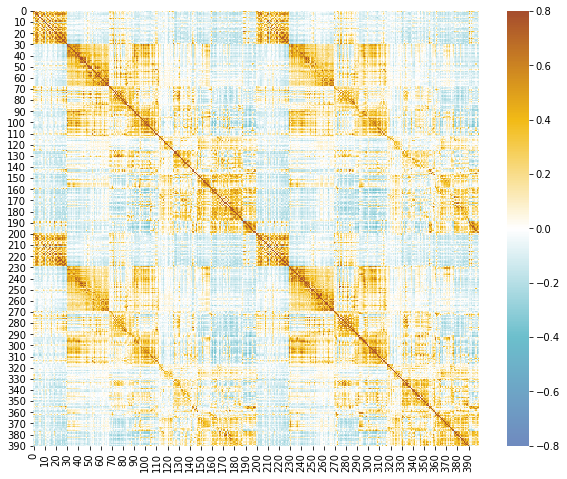

In [17]:
plt.figure(figsize=(10,8))
sns.heatmap(mean_connectivity_matrix_children,cmap=cmap,square=True,robust=False,cbar=True,
                vmin=-0.8,vmax=0.8,center=0)

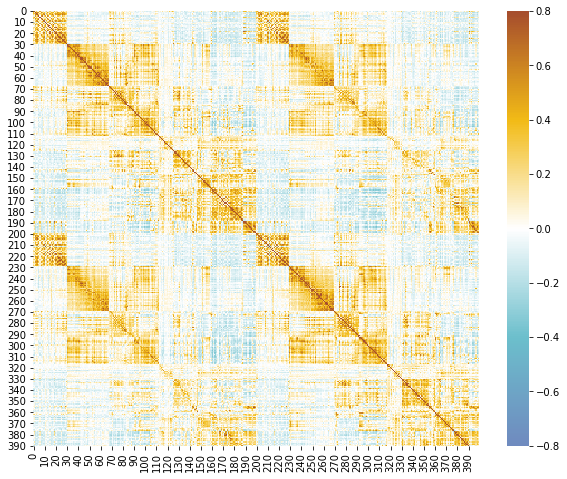

In [18]:
plt.figure(figsize=(10,8))
sns.heatmap(mean_connectivity_matrix_adults,cmap=cmap,square=True,robust=False,cbar=True,
                vmin=-0.8,vmax=0.8,center=0)

In [ ]:
# Let's look at the first subjects connectome in anatomical space
# See = https://nilearn.github.io/modules/generated/nilearn.plotting.plot_connectome.html#nilearn.plotting.plot_connectome
# RdYlBu_r

coords = plot.find_parcellation_cut_coords(atlas.maps)
connectome = plot.plot_connectome(correlation_matrix[50], 
                                  node_coords=coords,
                                  edge_threshold=0.3,
                                  edge_cmap = 'RdYlBu_r',
                                  node_size=30,
                                  annotate=True,
                                  colorbar=True)
connectome

In [ ]:
# Let's look at the first subjects connectome in anatomical space
# See = https://nilearn.github.io/modules/generated/nilearn.plotting.view_connectome.html#nilearn.plotting.view_connectome

coords = plot.find_parcellation_cut_coords(atlas.maps)
connectome = plot.view_connectome(correlation_matrix[50], 
                                  node_coords=coords,
                                  edge_threshold=0.80,
                                  linewidth=10)
connectome

See: https://nilearn.github.io/auto_examples/03_connectivity/plot_signal_extraction.html#sphx-glr-auto-examples-03-connectivity-plot-signal-extraction-py

___

# 3) ANALYSIS: FC-similarity group comparison

In [56]:
# Let's make sure we give the diagonal a 0 value so we can find the highest correlation value without 
# hitting the diagonal
subjects_connectome_correlation_matrix.values[[np.arange(subjects_connectome_correlation_matrix.shape[0])]*2] = 0
subjects_connectome_correlation_matrix.head()

BL065-1   BL065-2   BL067-1   BL067-2   BL073-1   BL076-1   BL077-1  \
BL065-1  0.000000  0.304780  0.203545  0.227219  0.207894  0.221633  0.212752   
BL065-2  0.304780  0.000000  0.203215  0.224797  0.193283  0.214627  0.204897   
BL067-1  0.203545  0.203215  0.000000  0.253988  0.179931  0.195484  0.183020   
BL067-2  0.227219  0.224797  0.253988  0.000000  0.192262  0.209283  0.201428   
BL073-1  0.207894  0.193283  0.179931  0.192262  0.000000  0.194246  0.192083   

          BL077-2   BL081-1   BL081-2  ...  BL2032-1  BL2061-1  BL2062-1  \
BL065-1  0.217366  0.215354  0.218195  ...  0.161819  0.196580  0.177797   
BL065-2  0.221498  0.208085  0.223999  ...  0.168583  0.195298  0.171519   
BL067-1  0.202636  0.195331  0.199679  ...  0.152507  0.178458  0.175188   
BL067-2  0.233505  0.207358  0.216940  ...  0.157960  0.197118  0.186305   
BL073-1  0.192385  0.192346  0.196562  ...  0.153403  0.164300  0.170866   

         BL2092-1  BL2101-1  BL2102-1  BL2121-1  BL2141-1  BL2171-1  BL2172-1  
BL065-1  0.200111  0.163723  0.197117  0.178888  0.175539  0.192746  0.174953  
BL065-2  0.204799  0.162597  0.196418  0.172940  0.172742  0.187379  0.174554  
BL067-1  0.188946  0.152402  0.168537  0.148246  0.166784  0.165330  0.167204  
BL067-2  0.201061  0.153126  0.182477  0.178932  0.175589  0.174964  0.181614  
BL073-1  0.192440  0.154273  0.178368  0.158484  0.161558  0.172729  0.164233  

[5 rows x 168 columns]

In [90]:
subjects_connectome_correlation_matrix.shape

(168, 168)

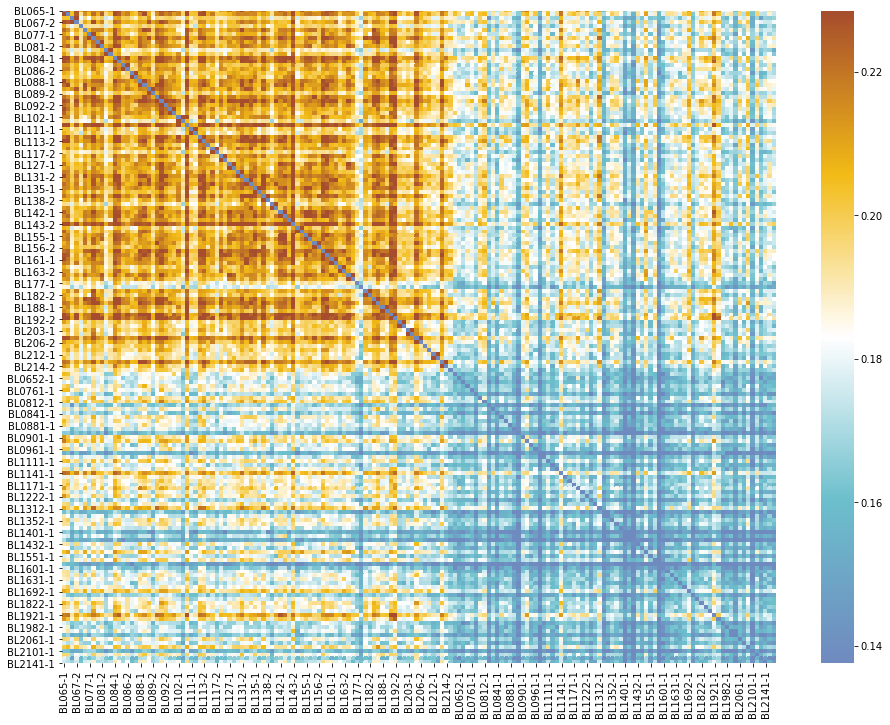

In [57]:
# let's look at the heatmap of our subjects connectivity map associations #cmaps: YlGnBu, 
# sns.heatmap(subjects_connectome_correlation_matrix,cmap="OrRd",vmin=0.1,vmax=0.35)
plt.figure(figsize=(16,12))
sns.heatmap(subjects_connectome_correlation_matrix,
                    robust=True,cmap=cmap)

In [58]:
subjects_connectome_correlation_matrix

BL065-1   BL065-2   BL067-1   BL067-2   BL073-1   BL076-1  \
BL065-1   0.000000  0.304780  0.203545  0.227219  0.207894  0.221633   
BL065-2   0.304780  0.000000  0.203215  0.224797  0.193283  0.214627   
BL067-1   0.203545  0.203215  0.000000  0.253988  0.179931  0.195484   
BL067-2   0.227219  0.224797  0.253988  0.000000  0.192262  0.209283   
BL073-1   0.207894  0.193283  0.179931  0.192262  0.000000  0.194246   
...            ...       ...       ...       ...       ...       ...   
BL2102-1  0.197117  0.196418  0.168537  0.182477  0.178368  0.186471   
BL2121-1  0.178888  0.172940  0.148246  0.178932  0.158484  0.169390   
BL2141-1  0.175539  0.172742  0.166784  0.175589  0.161558  0.175992   
BL2171-1  0.192746  0.187379  0.165330  0.174964  0.172729  0.176089   
BL2172-1  0.174953  0.174554  0.167204  0.181614  0.164233  0.169903   

           BL077-1   BL077-2   BL081-1   BL081-2  ...  BL2032-1  BL2061-1  \
BL065-1   0.212752  0.217366  0.215354  0.218195  ...  0.161819  0.196580   
BL065-2   0.204897  0.221498  0.208085  0.223999  ...  0.168583  0.195298   
BL067-1   0.183020  0.202636  0.195331  0.199679  ...  0.152507  0.178458   
BL067-2   0.201428  0.233505  0.207358  0.216940  ...  0.157960  0.197118   
BL073-1   0.192083  0.192385  0.192346  0.196562  ...  0.153403  0.164300   
...            ...       ...       ...       ...  ...       ...       ...   
BL2102-1  0.175321  0.198298  0.189328  0.190141  ...  0.148457  0.172696   
BL2121-1  0.161608  0.167708  0.176447  0.173295  ...  0.137896  0.155996   
BL2141-1  0.178100  0.187978  0.169437  0.172687  ...  0.138627  0.148548   
BL2171-1  0.167931  0.184941  0.183263  0.186754  ...  0.144929  0.160134   
BL2172-1  0.173854  0.191370  0.178366  0.188088  ...  0.139888  0.154013   

          BL2062-1  BL2092-1  BL2101-1  BL2102-1  BL2121-1  BL2141-1  \
BL065-1   0.177797  0.200111  0.163723  0.197117  0.178888  0.175539   
BL065-2   0.171519  0.204799  0.162597  0.196418  0.172940  0.172742   
BL067-1   0.175188  0.188946  0.152402  0.168537  0.148246  0.166784   
BL067-2   0.186305  0.201061  0.153126  0.182477  0.178932  0.175589   
BL073-1   0.170866  0.192440  0.154273  0.178368  0.158484  0.161558   
...            ...       ...       ...       ...       ...       ...   
BL2102-1  0.158642  0.178401  0.149222  0.000000  0.155043  0.165498   
BL2121-1  0.149974  0.160024  0.132516  0.155043  0.000000  0.146694   
BL2141-1  0.154531  0.166780  0.141165  0.165498  0.146694  0.000000   
BL2171-1  0.147432  0.170960  0.147159  0.171098  0.139942  0.155409   
BL2172-1  0.143803  0.168179  0.141754  0.157247  0.138774  0.143388   

          BL2171-1  BL2172-1  
BL065-1   0.192746  0.174953  
BL065-2   0.187379  0.174554  
BL067-1   0.165330  0.167204  
BL067-2   0.174964  0.181614  
BL073-1   0.172729  0.164233  
...            ...       ...  
BL2102-1  0.171098  0.157247  
BL2121-1  0.139942  0.138774  
BL2141-1  0.155409  0.143388  
BL2171-1  0.000000  0.151093  
BL2172-1  0.151093  0.000000  

[168 rows x 168 columns]

In [ ]:
# Find max value per subject and print that other subjects ID 
# df1 = df.loc[:, ~df.columns.str.contains('Name$')]

subjects_session_list_no_ses_2 = list(subjects_connectome_correlation_matrix_no_ses_2)
matches = []
false_matches = []

for sub in subjects_session_list_no_ses_2:
    
    column = subjects_connectome_correlation_matrix_no_ses_2[sub]
    highest_association = column.max()
    highest_association_id = column.idxmax()
    print('------ For:', sub)
    print('The highest connectivity matrix similarity was found with: ',highest_association_id, 'value: ',highest_association)
    
    if sub[0:5] == highest_association_id[0:5]:
        print('MATCH!!!')
        matches.append(1)
        
    else:
        print('NO Match')
        false_matches.append(0)
        
# Count the percentage of Within Subjects HIT 
number_of_matches = matches.count(1)
print('NUMBER OF MATCHES: ',number_of_matches)
print('NUMBER OF FALSE Matches: ',false_matches.count(0))

match_percentage = number_of_matches/len(subjects_session_list_no_ses_2)
print('FINAL MATCH PERCENTAGE: ',match_percentage*100, '%' )

In [ ]:
subjects_connectome_correlation_matrix_no_ses_2.head()

## 3.1) Create group labels for each pair

In [255]:
# Create figure showing group comparison results of all correlations for group 1) Family 2) Strangers
# data = new pandas DataFrame
# x = two groups: 1) within families and 2) Unrelated
# y = Outcome variable of correlation values

## A: Let's create the Dataframe and fill it with the properly formatted data
# See: https://stackoverflow.com/questions/34417685/melt-the-upper-triangular-matrix-of-a-pandas-dataframe

group_comparison = subjects_connectome_correlation_matrix.stack().reset_index()
group_comparison.columns = ['Subject','Target','Value']
group_comparison['Group'] = ''

# Let's quickly drop the diagonal values between identical subjects
group_comparison=group_comparison[group_comparison!=0].dropna()
group_comparison_family_vs_unrelated = group_comparison.copy()


## A2: We need to provide the dataframe with the right group

def group_value_fam_unrel(row):
    
    if row["Subject"][0:5] == row["Target"][0:5] and len(row["Subject"]) > 7 and len(row["Target"]) > 7:
        result = 'Family'
        
    elif row["Subject"][0:5] == row["Target"][0:5] and len(row["Subject"]) > 7:
        result = 'Family'
        
    elif row["Subject"][0:5] == row["Target"][0:5] and len(row["Target"]) > 7:
        result = 'Family'
        
    elif row["Subject"][0:5] == row["Target"][0:5] and len(row["Subject"]) == len(row["Target"]):
        result = 'Within Subject'
        
    elif len(row["Target"]) > 7 and len(row["Subject"]) > 7:
        result = 'Unrelated'
        
    elif len(row["Target"]) == 7 and len(row["Subject"]) == 7:
        result = 'Unrelated'
        
    else:
        result = 'Unrelated'
    return result

def group_value(row):
    
    if row["Subject"][0:5] == row["Target"][0:5] and len(row["Subject"]) > 7 and len(row["Target"]) > 7:
        result = 'Family P/P'
        
    elif row["Subject"][0:5] == row["Target"][0:5] and len(row["Subject"]) > 7:
        result = 'Family P/C'
        
    elif row["Subject"][0:5] == row["Target"][0:5] and len(row["Target"]) > 7:
        result = 'Family P/C'
        
    elif row["Subject"][0:5] == row["Target"][0:5] and len(row["Subject"]) == len(row["Target"]):
        result = 'Within Subject'
        
    elif len(row["Target"]) > 7 and len(row["Subject"]) > 7:
        result = 'Unrelated A/A'
        
    elif len(row["Target"]) == 7 and len(row["Subject"]) == 7:
        result = 'Unrelated C/C'
        
    else:
        result = 'Unrelated C/A'
    return result

group_comparison['Group'] = group_comparison.apply(lambda row : group_value(row), axis=1) 
group_comparison_family_vs_unrelated['Group'] = group_comparison_family_vs_unrelated.apply(lambda row : group_value_fam_unrel(row),axis=1)

# Now we need to remove the double entries for within subject BL065-1 <-> BL0652 is in it twice
group_comparison_clean = group_comparison.drop_duplicates(subset='Value',inplace=False,keep='first')
group_comparison_clean.rename(columns={'Value':'Similarity'},inplace=True)

group_comparison_family_vs_unrelated.drop_duplicates(subset='Value',inplace=True, keep='first')
group_comparison_family_vs_unrelated.rename(columns={'Value':'Similarity'},inplace=True)

print(group_comparison_clean.groupby('Group').count())
group_comparison_clean.to_csv('group_comparison.csv')

# df = df[~df['your column'].isin(['list of strings'])]
group_comparison_family_only = group_comparison_clean[~group_comparison_clean['Group'].isin(['Unrelated C/C','Unrelated A/A','Unrelated C/A'])]

group_comparison_clean

                Subject  Target  Similarity
Group                                      
Family P/C          138     138         138
Family P/P           25      25          25
Unrelated A/A      2825    2825        2825
Unrelated C/A      6854    6854        6854
Unrelated C/C      4144    4144        4144
Within Subject       42      42          42


Subject    Target  Similarity           Group
1       BL065-1   BL065-2    0.304780  Within Subject
2       BL065-1   BL067-1    0.203545   Unrelated C/C
3       BL065-1   BL067-2    0.227219   Unrelated C/C
4       BL065-1   BL073-1    0.207894   Unrelated C/C
5       BL065-1   BL076-1    0.221633   Unrelated C/C
...         ...       ...         ...             ...
27718  BL2121-1  BL2171-1    0.139942   Unrelated A/A
27719  BL2121-1  BL2172-1    0.138774   Unrelated A/A
27886  BL2141-1  BL2171-1    0.155409   Unrelated A/A
27887  BL2141-1  BL2172-1    0.143388   Unrelated A/A
28055  BL2171-1  BL2172-1    0.151093      Family P/P

[14028 rows x 4 columns]

In [244]:
group_comparison_family_only.groupby('Group').count()

Subject  Target  Similarity
Group                                      
Family P/C          138     138         138
Family P/P           25      25          25
Within Subject       42      42          42

In [256]:
group_comparison_family_vs_unrelated.groupby('Group').count()

Subject  Target  Similarity
Group                                      
Family              163     163         163
Unrelated         13823   13823       13823
Within Subject       42      42          42

## 3.2) Group comparison - Figures

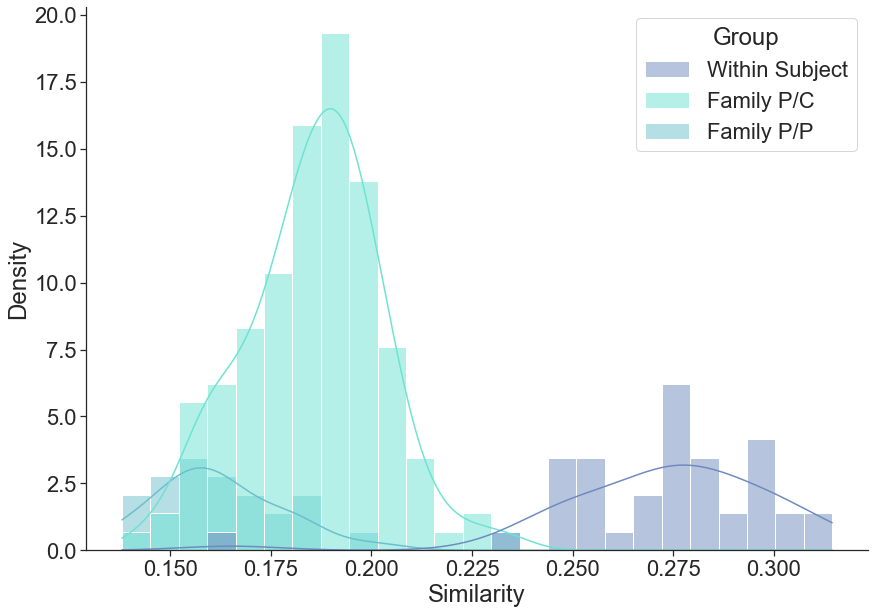

In [220]:
## B: Let's plot the group comparison
plt.figure(figsize=(14,10))
sns.histplot(data=group_comparison_family_only,x='Similarity',hue='Group',bins=25,common_norm=True,
             stat='density',multiple='layer',kde=True,
           palette=[within_color,family_parent_child_color,family_parent_parent_color])
sns.despine()

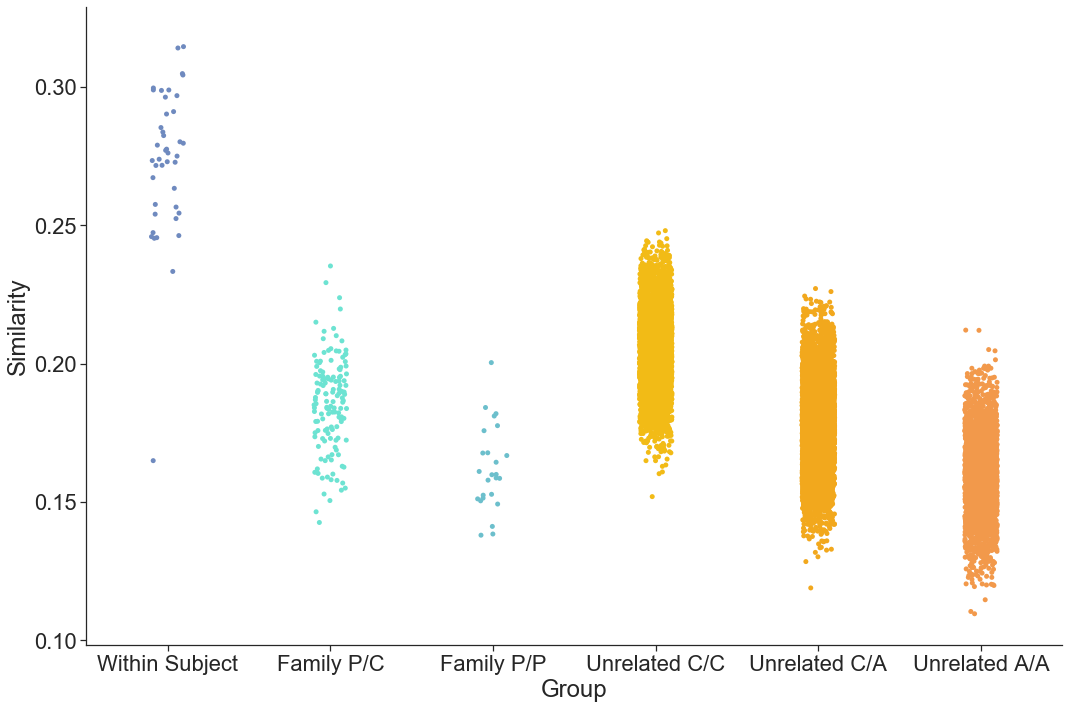

In [232]:
sns.catplot(data=group_comparison_clean,x='Group',y='Similarity',kind='strip',
            order=['Within Subject','Family P/C','Family P/P','Unrelated C/C','Unrelated C/A',
                   'Unrelated A/A'],height=10,aspect=1.5,
           palette=[within_color,family_parent_child_color,family_parent_parent_color,child_child_color,child_adult_color,adult_adult_color])
sns.despine()

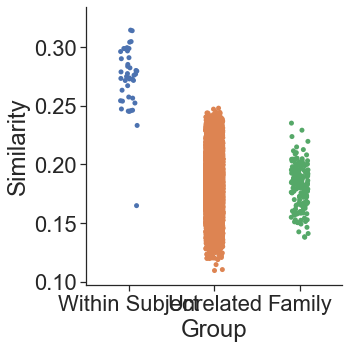

In [257]:
sns.catplot(data=group_comparison_family_vs_unrelated, x='Group',y='Similarity')

In [231]:
import pingouin as pg
# See: https://pingouin-stats.org
aov = pg.anova(data=group_comparison_clean, dv='Similarity', between='Group', detailed=True)
print(aov)

# FDR-corrected post hocs with Hedges'g effect size
posthocs = pg.pairwise_ttests(data=group_comparison_clean, dv='Similarity', within='Group', subject='Subject',
                             parametric=True, padjust='fdr_bh', effsize='hedges')

posthocs.round(3)

   Source        SS     DF        MS            F  p-unc       np2
0   Group  3.988011      5  0.797602  3624.657132    0.0  0.563793
1  Within  3.085527  14022  0.000220          NaN    NaN       NaN


Contrast               A              B  Paired  Parametric        T  \
0     Group  Within Subject  Unrelated C/C    True        True   16.485   
1     Group  Within Subject     Family P/C    True        True   20.145   
2     Group  Within Subject  Unrelated C/A    True        True   22.947   
3     Group  Within Subject     Family P/P    True        True   21.762   
4     Group  Within Subject  Unrelated A/A    True        True   27.398   
5     Group   Unrelated C/C     Family P/C    True        True   13.681   
6     Group   Unrelated C/C  Unrelated C/A    True        True   92.453   
7     Group   Unrelated C/C     Family P/P    True        True   14.233   
8     Group   Unrelated C/C  Unrelated A/A    True        True  125.361   
9     Group      Family P/C  Unrelated C/A    True        True    4.668   
10    Group      Family P/C     Family P/P    True        True    7.035   
11    Group      Family P/C  Unrelated A/A    True        True   17.280   
12    Group   Unrelated C/A     Family P/P    True        True    5.554   
13    Group   Unrelated C/A  Unrelated A/A    True        True   55.268   
14    Group      Family P/P  Unrelated A/A    True        True    0.492   

         dof       Tail  p-unc  p-corr p-adjust        BF10  hedges  
0     41.242  two-sided  0.000   0.000   fdr_bh   1.944e+55   4.664  
1     51.318  two-sided  0.000   0.000   fdr_bh   1.131e+44   4.473  
2     41.158  two-sided  0.000   0.000   fdr_bh  1.056e+108   6.276  
3     64.943  two-sided  0.000   0.000   fdr_bh   9.566e+27   4.766  
4     41.385  two-sided  0.000   0.000   fdr_bh  3.139e+142   7.435  
5    143.750  two-sided  0.000   0.000   fdr_bh   1.588e+38   1.370  
6   9002.821  two-sided  0.000   0.000   fdr_bh         inf   1.802  
7     24.258  two-sided  0.000   0.000   fdr_bh   1.212e+41   3.025  
8   5907.294  two-sided  0.000   0.000   fdr_bh         inf   3.081  
9    141.394  two-sided  0.000   0.000   fdr_bh    3885.088   0.449  
10    35.438  two-sided  0.000   0.000   fdr_bh   1.213e+08   1.422  
11   147.774  two-sided  0.000   0.000   fdr_bh    1.11e+60   1.675  
12    24.169  two-sided  0.000   0.000   fdr_bh   3.278e+05   1.135  
13  5262.684  two-sided  0.000   0.000   fdr_bh         inf   1.236  
14    24.410  two-sided  0.627   0.627   fdr_bh       0.235   0.101

In [258]:
import pingouin as pg
# See: https://pingouin-stats.org
aov = pg.anova(data=group_comparison_family_vs_unrelated, dv='Similarity', between='Group', detailed=True)
print(aov)

# FDR-corrected post hocs with Hedges'g effect size
posthocs = pg.pairwise_ttests(data=group_comparison_family_vs_unrelated, dv='Similarity', within='Group', subject='Subject',
                             parametric=True, padjust='fdr_bh', effsize='hedges')

posthocs.round(3)

   Source        SS     DF        MS          F          p-unc      np2
0   Group  0.340521      2  0.170261  354.65634  5.534504e-151  0.04814
1  Within  6.733016  14025  0.000480        NaN            NaN      NaN


Contrast               A          B  Paired  Parametric       T      dof  \
0    Group  Within Subject  Unrelated    True        True  21.928   41.169   
1    Group  Within Subject     Family    True        True  20.936   51.770   
2    Group       Unrelated     Family    True        True   0.739  167.351   

        Tail  p-unc  p-corr p-adjust        BF10  hedges  
0  two-sided  0.000   0.000   fdr_bh  3.273e+100   4.107  
1  two-sided  0.000   0.000   fdr_bh   6.543e+48   4.439  
2  two-sided  0.461   0.461   fdr_bh       0.115   0.050

___

# 4) Inter-subject variability (child vs adults)

Intersubject variance (ISV) per region was defined as the
average cosine distance between structural/functional connectivities across subjects. We further grouped ROIs
into clusters to compare multimodal ISV.

- use cosine distance (CD) 
- see: https://cmry.github.io/notes/euclidean-v-cosine

- Latex use: https://nbviewer.jupyter.org/github/twistedhardware/mltutorial/blob/master/notebooks/jupyter/2.%20Markdown%20%26%20LaTeX.ipynb


Eucledian distance (d) and Cosine similarity (distance) O
$$
\frac{(x \cdot y)}{(x \cdot x)*(y \cdot y)}
$$

- prep data to run through every child with 2 scan sessions (1 year apart)
- Calculate ISV across the whole functional connectome (400x400)

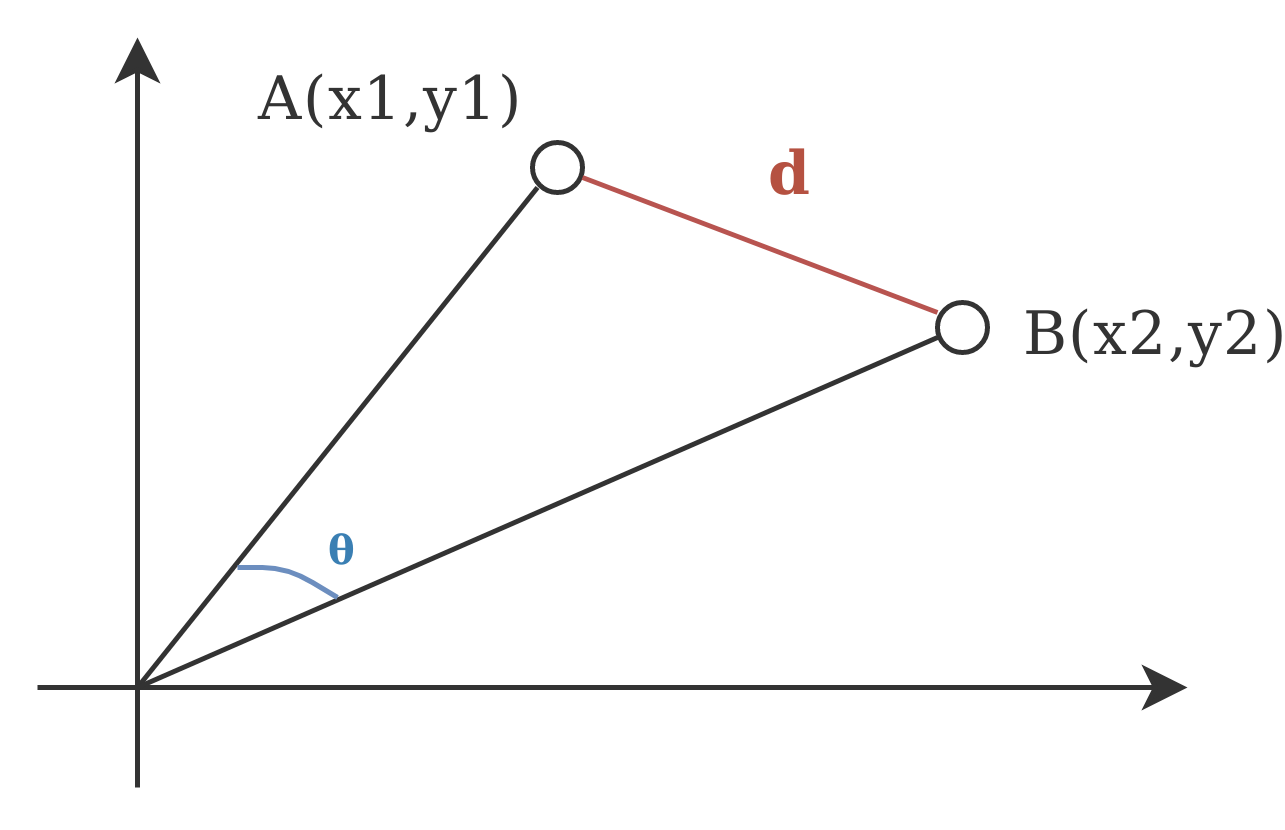

In [37]:
Image('https://cmry.github.io/sources/eucos.png')

## 4.1) Intra-subject variability T1-T2 (children only)

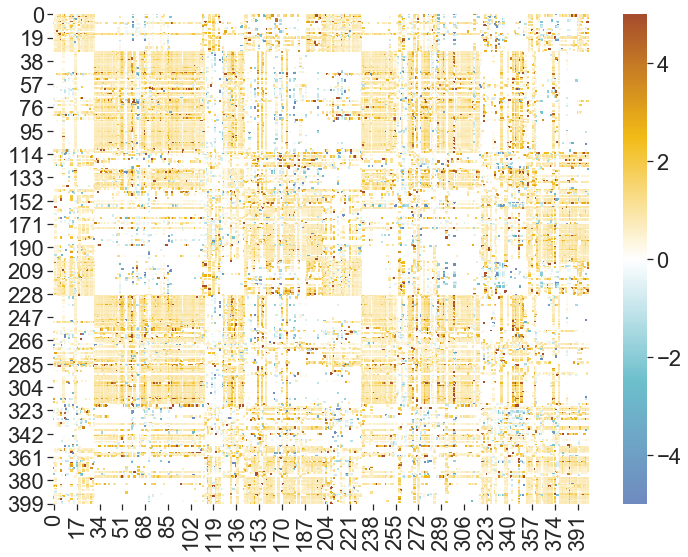

In [39]:
def cosine_similarity(x, y):
    return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))

sub1_connectome_ses_1 = correlation_matrix[5]
sub1_connectome_ses_2 = correlation_matrix[60]

sub1_connectome_var = cosine_similarity(sub1_connectome_ses_1,sub1_connectome_ses_2)

plt.figure(figsize=(12,9))
sns.heatmap(sub1_connectome_var,cmap=cmap,vmin=-5,vmax=5)

### Correlate children ISV with their age (8-18)

### Calculate Inter-subject variance for child and adult sample

___

# 5) Classification

## Load all packages & prep data

In [59]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import metrics
import statsmodels.api as sm
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold

from math import sqrt
import ppscore as pps
import warnings
import difflib 
from IPython.display import Image

warnings.filterwarnings('ignore')

In [27]:
## Let's create a function that fills every row with the correct ages & age difference
covariates = pd.read_csv('/Users/philipb/surfdrive/PhD/BRAINLINKS/T1_Ouderstudie/Covariates_T1_ouder.csv')
group_comparison_clean = pd.read_csv('group_comparison.csv')
# family_classifier = pd.read_csv('ML_family_classifier.csv')
group_comparison_clean

Unnamed: 0   Subject    Target  Similarity           Group
0               1   BL065-1   BL065-2    0.304780  Within Subject
1               2   BL065-1   BL067-1    0.203545   Unrelated C/C
2               3   BL065-1   BL067-2    0.227219   Unrelated C/C
3               4   BL065-1   BL073-1    0.207894   Unrelated C/C
4               5   BL065-1   BL076-1    0.221633   Unrelated C/C
...           ...       ...       ...         ...             ...
14023       27718  BL2121-1  BL2171-1    0.139942   Unrelated A/A
14024       27719  BL2121-1  BL2172-1    0.138774   Unrelated A/A
14025       27886  BL2141-1  BL2171-1    0.155409   Unrelated A/A
14026       27887  BL2141-1  BL2172-1    0.143388   Unrelated A/A
14027       28055  BL2171-1  BL2172-1    0.151093      Family P/P

[14028 rows x 5 columns]

In [ ]:
# Combine subject and their covariates (age, motion, personality)
group_comparison_clean['Subject'] = group_comparison_clean['Subject'].map(lambda x: difflib.get_close_matches(x, covariates['subject'])[0])
subject_merged = group_comparison_clean.merge(covariates, left_on = 'Subject', right_on = 'subject', how = 'outer').drop('subject', axis = 1)
subject_merged.rename(columns={"age":"subject_age","fd_motion":"subject_fd_motion","H":"H1","E":"E1","X":"X1","A":"A1","C":"C1","O":"O1"},inplace=True)

subject_merged.to_csv('subject_merged.csv')

# Now we do the same with the target participant
group_comparison_clean['Target'] = group_comparison_clean['Target'].map(lambda x: difflib.get_close_matches(x, covariates['subject'])[0])
target_merged = group_comparison_clean.merge(covariates, left_on = 'Target', right_on = 'subject', how = 'outer').drop('subject', axis = 1)
target_merged.rename(columns={"Subject":"Subject2","Target":"Target2","Group":"Group2","age":"target_age","fd_motion":"target_fd_motion","H":"H2","E":"E2","X":"X2","A":"A2","C":"C2","O":"O2"},inplace=True)

target_merged.to_csv('target_merged.csv')

In [ ]:
#Pandas merge: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html
# see also: https://towardsdatascience.com/why-and-how-to-use-merge-with-pandas-in-python-548600f7e738

# Now we merge the two DataFrames
predict_final = pd.merge(subject_merged,target_merged, on='Similarity',how = 'inner',
                         indicator=False).drop(['Subject2','Target','Group2'],axis=1)

# We add additional variables based on the difference of subject and target (age, personality, and movement)
predict_final = predict_final.assign(age_diff = abs(predict_final['subject_age'] - predict_final['target_age']))
predict_final = predict_final.assign(H_diff = abs(predict_final['H1'] - predict_final['H2']))
predict_final = predict_final.assign(E_diff = abs(predict_final['E1'] - predict_final['E2']))
predict_final = predict_final.assign(X_diff = abs(predict_final['X1'] - predict_final['X2']))
predict_final = predict_final.assign(A_diff = abs(predict_final['A1'] - predict_final['A2']))
predict_final = predict_final.assign(C_diff = abs(predict_final['C1'] - predict_final['C2']))
predict_final = predict_final.assign(O_diff = abs(predict_final['O1'] - predict_final['O2']))
predict_final = predict_final.assign(fd_diff = abs(predict_final['target_fd_motion'] - predict_final['subject_fd_motion']))
predict_final['personality_diff'] = predict_final[['H_diff','E_diff','X_diff','A_diff','C_diff','O_diff']].mean(axis=1)
predict_final['fd_avg'] = predict_final[['target_fd_motion','subject_fd_motion']].mean(axis=1)

# We clean the dataset and drop unnecessary columns like individual personality traits and empty rows
predict_final.drop(['subject_age','target_age','subject_fd_motion','target_fd_motion','fd_diff','H1','H2','E1','E2','X1','X2','A1','A2','C1','C2','O1','O2',
                   'H_diff','E_diff','X_diff','A_diff','C_diff','O_diff'],axis=1,inplace=True)

predict_final = predict_final[['Subject','Target2','Similarity','Group','age_diff','fd_avg','personality_diff']]
predict_final.drop_duplicates(subset='Similarity',keep='first',ignore_index=True)
# predict_final.dropna(axis=0,inplace=True,subset=["Subject","Group","similarity"])

predict_final.to_csv('prediction_final.csv')
predict_final


For the baseline identification approach we will replicate Finn et al. (2015) paper. Every adolescent participant's functional conectome will be correlated with all the others in our sample. If the highest correlation is either the mum or the dad we accept it as a correct classifaction. If any other, non-familial, participant shows the highest correlation with the adolescent the family identification will be considered incorrect.

**Additional exploratory classification**
See if we can classify the different participants into the different relationship groups:
- Within
- Family
- Child-Child
- Child-Adult
- Adult-Adult

**Hypotheses**
- Family classification (E1)
- Parent-child dyads > Parent-parent dyads?

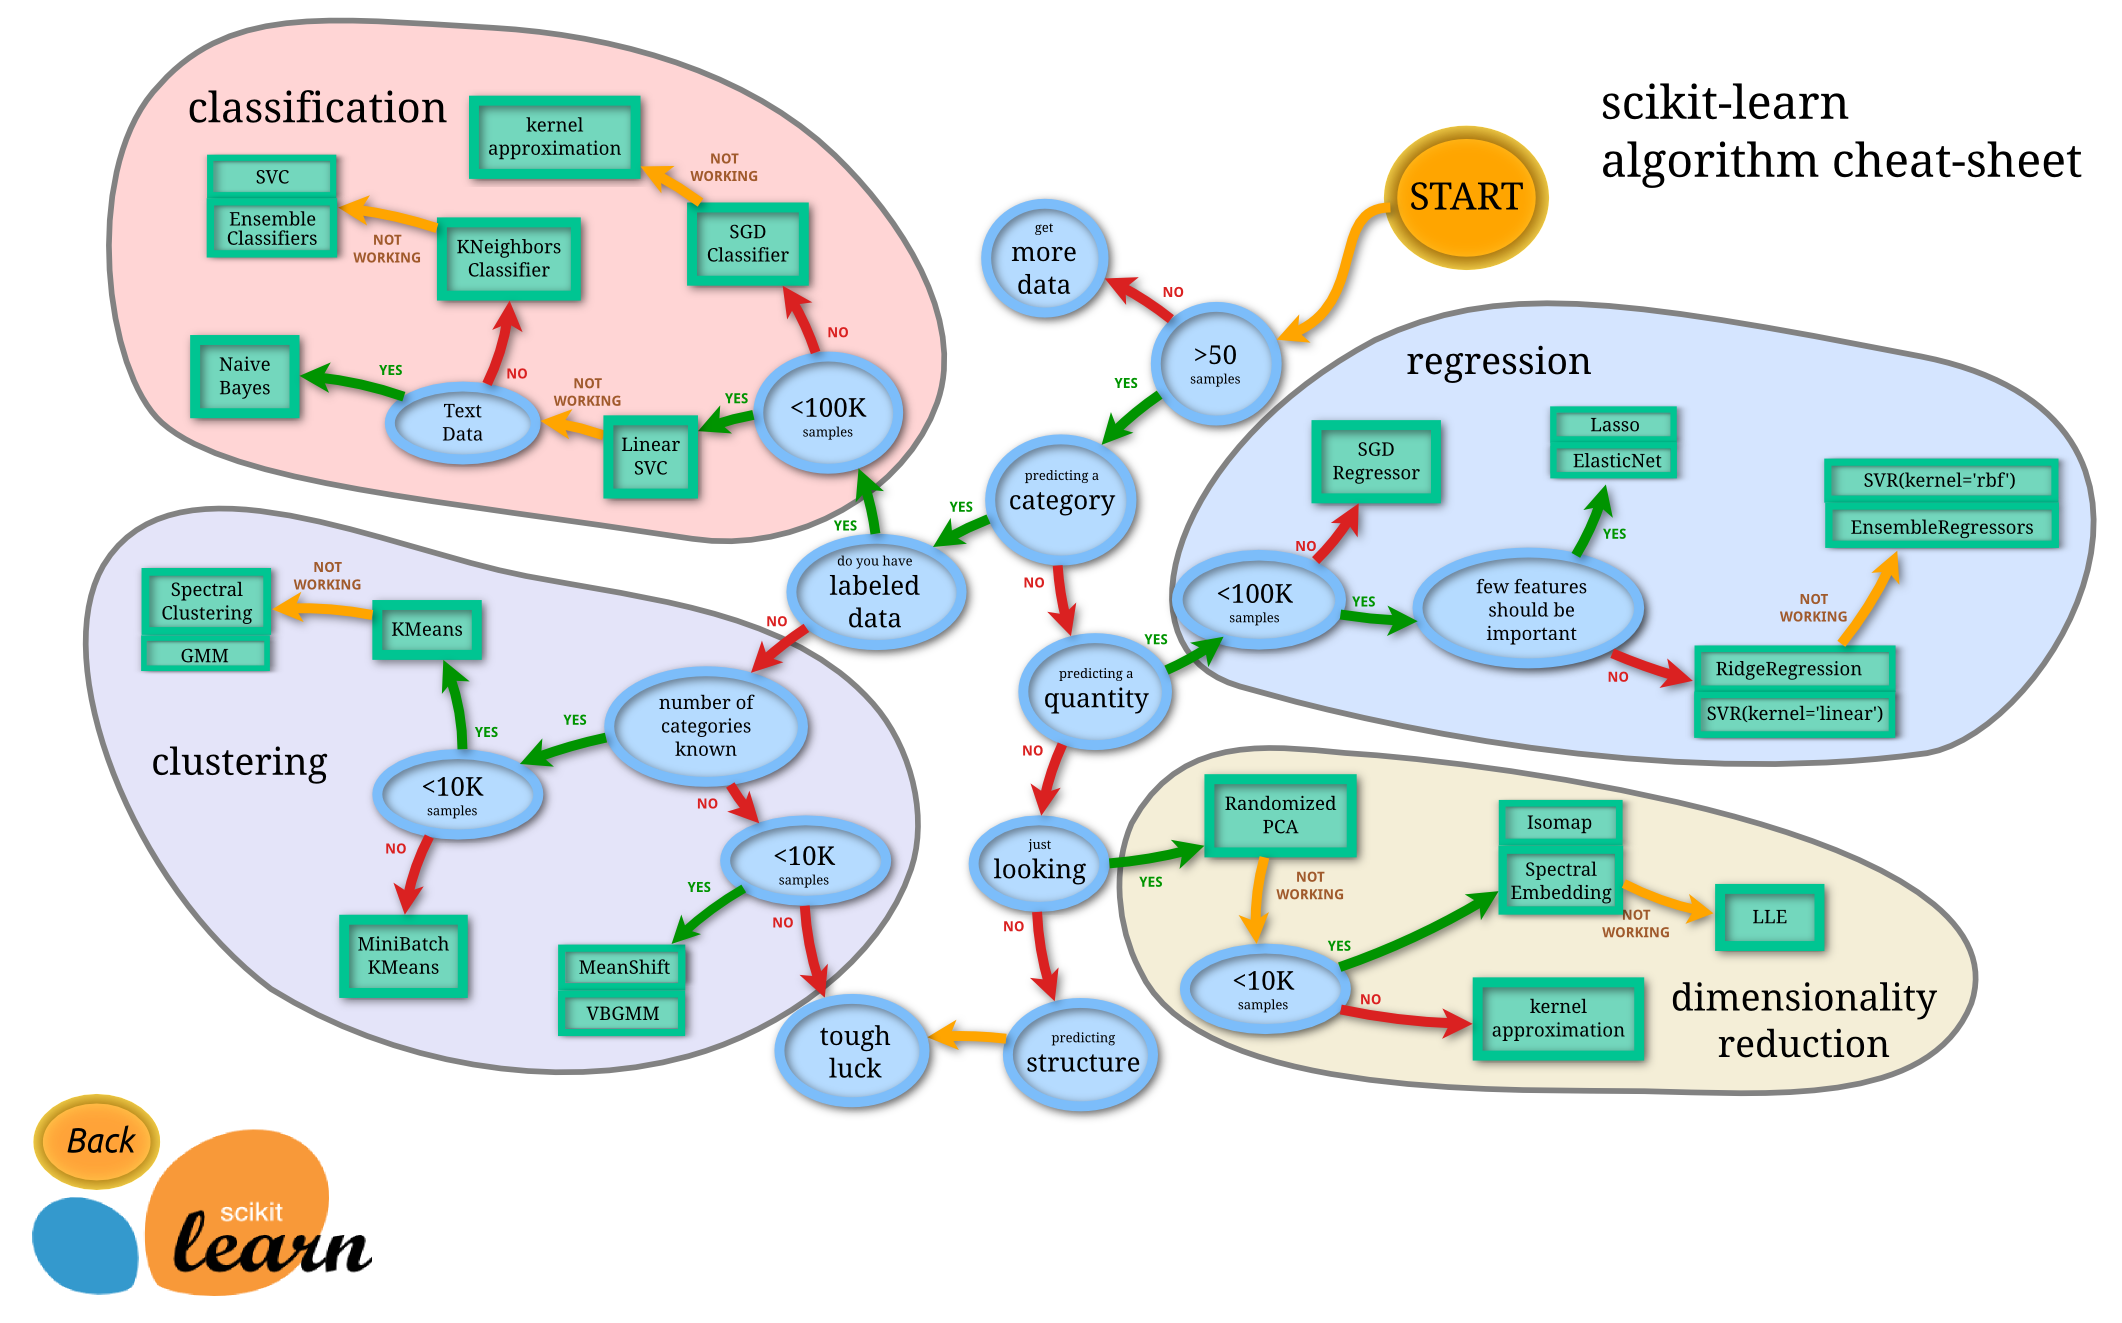

In [32]:
Image('https://scikit-learn.org/stable/_static/ml_map.png')

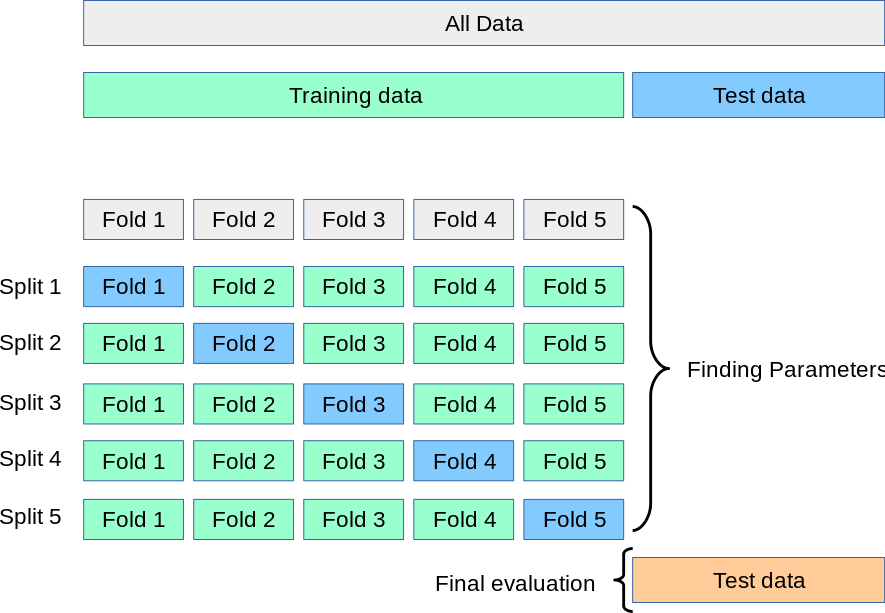

In [33]:
Image('https://scikit-learn.org/stable/_images/grid_search_cross_validation.png')

## Explore data

In [ ]:
plt.figure(figsize=(10,6))
sns.regplot(data=predict_final,x='similarity',y='personality_diff')
sns.despine()

In [ ]:
pg.corr(predict_final['similarity'],predict_final['personality_diff'],method='spearman').round(3)

In [ ]:
plt.figure(figsize=(10,6))
sns.regplot(data=predict_final,x='age_diff',y='personality_diff')
sns.despine()

In [ ]:
plt.figure(figsize=(10,8))
sns.histplot(data=predict_final,x='personality_diff',hue='Group',bins=25,
           palette=[within_color,child_child_color,family_color,child_adult_color,adult_adult_color])
sns.despine()

In [ ]:

pps_matrix = pps.matrix(predict_final)
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(pps_matrix, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)

## Feature selection

**160,000/2** features are too many. We need to cut this down to a more managable number so we can run more intensive models (like Polynomial regression for age later).

**Resources**
- https://towardsdatascience.com/how-to-use-variance-thresholding-for-robust-feature-selection-a4503f2b5c3f
- https://chrisalbon.com/machine_learning/feature_selection/variance_thresholding_for_feature_selection/
- https://chrisalbon.com/machine_learning/feature_selection/anova_f-value_for_feature_selection/
- https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/


**Options**
- High Variance thresholding: DIDN'T WORK none of the features have enough variance??
- ANOVA F-value selection
- Drop highly correlated features


**High Variance thresholding**

In [78]:
# First we create a feature thresholder object
connectome_thresholder = VarianceThreshold(threshold=0.0001)
print('Number of features raw full connectivity matrix: ',family_classifier.shape[0])

# Conduct the variance thresholding by transforming the data
connectomes_high_variance = connectome_thresholder.fit_transform(family_classifier)
print('Number of features after thresholding: ',connectomes_high_variance.shape[0])

Number of features raw full connectivity matrix:  79800
Number of features after thresholding:  79800


**ANOVA f-value selection**

In [101]:
np.savetxt('famly_classifier_test.csv',family_classifier,delimiter=',')

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

print(family_classifier.shape)
print(y_age_final.shape)

# Create f-value selector object
fvalue_selector = SelectKBest(f_classif,k=2)

# Apply the kbest selector to our features and target value (different for every problem)
X_age_kbest = fvalue_selector.fit_transform(family_classifier,y_age_final)

# Show results
print('Original number of features: ',family_classifier.shape[0])
print('Reduced number of features: ', X_age_kbest.shape[0])

**Delete high correlating features**

In [139]:
df_family_classifier = pd.DataFrame(family_classifier)
df_family_classifier
# connectome_classifier_corr = df_family_classifier.corr().abs()

TypeError: 'Series' object is not callable

TypeError: 'Series' object is not callable

## 5.1) Classification of Family Identity

In [47]:
# We start with the subject id's and family list of our sample -- 51 families in total

family_ids = [65,65,67,67,73,76,77,77,81,81,82,82,84,84,86,86,87,87,88,88,89,89,90,92,92,96,96,102,102,104,
              111,111,113,113,115,117,117,122,122,127,127,131,131,134,134,135,135,138,138,140,140,142,142,
              143,143,154,154,155,155,156,156,160,160,161,161,163,163,169,169,177,177,182,182,185,185,188,188,
              192,192,198,198,203,203,206,206,209,210,212,212,214,214,217,65,65,67,73,76,77,77,81,82,82,84,86,
              87,88,88,89,90,92,92,96,102,104,111,111,113,114,114,115,117,117,122,122,127,131,131,134,135,135,
              138,138,140,142,143,143,154,154,155,156,156,160,161,161,163,163,169,169,177,182,182,185,188,192,
              192,198,198,203,203,206,206,209,210,210,212,214,217,217          
             ]

family_labels = np.array([family_ids])
family_labels = family_labels.T
family_labels.shape

(168, 1)

In [48]:
# Here we have our 1-dimensional array representing our vectorized functional connectome (400x400 = 160,000)

print(family_classifier.shape)
print(family_labels.shape)

(79800, 168)
(168, 1)


In [ ]:
# Get the features and labels (indepdendent & outcome variable)
X_rfc = family_classifier
y_rfc = family_labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_rfc, y_rfc, test_size=0.3) # 70% training and 30% test

In [ ]:
# Initialize the random forest classifier & fit the model to the training dataset
# Bootstrap = bagging or sampling with replacement for the indivdual trees
rf_classy = RandomForestClassifier(n_estimators=1000,bootstrap=True,n_jobs=-1)
rf_classy.fit(X_train,y_train)

# Now let's predict our X_test set groups
rf_classy_y_pred = rf_classy.predict(X_test)

print('ACCURACY RFC (test): ',metrics.accuracy_score(y_test,rf_classy_y_pred))
print('PRECISION RFC (test): ',metrics.precision_score(y_test,rf_classy_y_pred,average="weighted"))

## 5.2) Classification of Adolescent vs Adult

In [ ]:
# We start with the labels for child (1) vs adult (0)

child_ids = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
             1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
             0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
             0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0       
             ]


child_labels = np.array([child_ids])
child_labels = child_labels.T
child_labels.shape

In [ ]:
print(family_classifier.shape)

In [ ]:
# Get the features and labels (indepdendent & outcome variable)
X_rfc = family_classifier
y_rfc = child_labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_rfc, y_rfc, test_size=0.3) # 70% training and 30% test

In [ ]:
# create a SVM classifier
svm_model = svm.SVC(kernel='linear')

# fit the model
svm_model.fit(X_train,y_train)

# Prediction
y_pred = svm_model.predict(X_test)

# Performance
svm_accuracy = metrics.accuracy_score(y_test,y_pred)
print('Accuracy:', svm_accuracy)

# Precision
print("Precision:",metrics.precision_score(y_test, y_pred))

# Recal 
print("Recall:",metrics.recall_score(y_test, y_pred))


In [ ]:
lrc = LogisticRegression()
lrc.fit(X_train,y_train)
lrc.score(X_test,y_test)

In [ ]:
rfc_child = RandomForestClassifier(n_estimators=50)
rfc_child.fit(X_train,y_train)
rfc_child.score(X_test,y_test)

### k-fold Cross-Validation

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=6)
kf

from sklearn.model_selection import StratifiedKFold
folds = StratifiedKFold(n_splits=3)

def get_score(model,X_train,X_test,y_train,y_test):
    model.fit(X_train,y_train)
    return model.score(X_test,y_test)

scores_svm = []
scores_lr = []
scores_rf = []

for train_index,test_index in kf.split(family_classifier):
    X_train,X_test,y_train,y_test = family_classifier[train_index], family_classifier[test_index], \
    child_labels[train_index],child_labels[test_index]
    
    scores_svm.append(get_score(svm.SVC(kernel='linear'),X_train,X_test,y_train,y_test))
    scores_lr.append(get_score(LogisticRegression(),X_train,X_test,y_train,y_test))
    scores_rf.append(get_score(RandomForestClassifier(n_estimators=50),X_train,X_test,y_train,y_test))

print('Scores SVM: ',scores_svm)
print('Scores Logistic Reg: ',scores_lr)
print('Scores RF: ',scores_rf)

### Visualize the SVM hyperplane

**Resources**
- https://chrisalbon.com/machine_learning/support_vector_machines/plot_support_vector_classifier_hyperplane/

___

# 6) Prediction

In this final part of the analyses we will try to predict similarity between functional connectomes of individuals based on a handful of features. Because our outcome variable is numerical (correlation as proxy for similarity) and not a classification (like with the family identity above) we could use one of the following machine-learning methods:

- Linear Regression (baseline model)
- Lasso (?)
- Random forrest
- Neural net

for more choices in ML-methods see: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

In [8]:
import sklearn
sklearn.__version__

'0.20.3'

- Don't forget to dummy code the categorical variable for GROUP so the regression model can use it

For details see:
- https://towardsdatascience.com/simple-and-multiple-linear-regression-with-python-c9ab422ec29c
- https://towardsdatascience.com/simple-and-multiple-linear-regression-with-python-c9ab422ec29c


In [96]:
predict_final_dummy = pd.get_dummies(predict_final,columns=['Group'],prefix='group')
predict_final_dummy.dropna(inplace=True,axis=0)
predict_final_dummy

Subject   Target2  similarity  age_diff  fd_avg  personality_diff  \
0       BL065-1   BL065-2    0.304780       1.0   0.110          0.000000   
1       BL065-1   BL065-1    0.304780       0.0   0.120          0.000000   
2       BL065-2   BL065-2    0.304780       0.0   0.100          0.000000   
3       BL065-2   BL065-1    0.304780       1.0   0.110          0.000000   
4       BL065-1   BL067-1    0.203545       0.1   0.115          0.583333   
...         ...       ...         ...       ...     ...               ...   
56097  BL2121-1  BL2172-1    0.138774       2.0   0.140          0.427083   
56098  BL2172-1  BL2121-1    0.138774       2.0   0.140          0.427083   
56099  BL2172-1  BL2172-1    0.138774       0.0   0.180          0.000000   
56107  BL2172-1  BL2172-1    0.143388       0.0   0.180          0.000000   
56111  BL2172-1  BL2172-1    0.151093       0.0   0.180          0.000000   

       group_Family (C/A & A/A)  group_Unrelated A/A  group_Unrelated C/A  \
0                             0                    0                    0   
1                             0                    0                    0   
2                             0                    0                    0   
3                             0                    0                    0   
4                             0                    0                    0   
...                         ...                  ...                  ...   
56097                         0                    1                    0   
56098                         0                    1                    0   
56099                         0                    1                    0   
56107                         0                    1                    0   
56111                         1                    0                    0   

       group_Unrelated C/C  group_Within Subject  
0                        0                     1  
1                        0                     1  
2                        0                     1  
3                        0                     1  
4                        1                     0  
...                    ...                   ...  
56097                    0                     0  
56098                    0                     0  
56099                    0                     0  
56107                    0                     0  
56111                    0                     0  

[35547 rows x 11 columns]

### Assumption checks

similarity  age_diff    fd_avg  personality_diff
similarity          1.000000 -0.123510  0.117643         -0.030866
age_diff           -0.123510  1.000000  0.004237          0.655548
fd_avg              0.117643  0.004237  1.000000          0.005055
personality_diff   -0.030866  0.655548  0.005055          1.000000

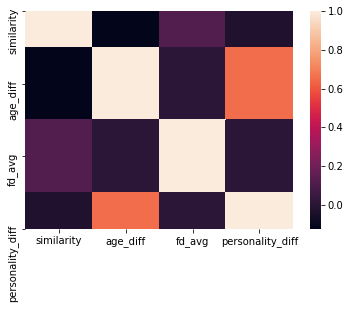

In [97]:
# Multicollinearity
multi_corr = predict_final.corr()
display(multi_corr)
sns.heatmap(multi_corr)

## We set our variables here

In [98]:
# Let's import sklearn for the regression model


# 1) Let's define our predictors Xs and our outcome variable Y
X = predict_final_dummy[['age_diff','fd_avg','personality_diff',
                       'group_Family (C/A & A/A)','group_Unrelated A/A','group_Within Subject',
                  'group_Unrelated C/C','group_Unrelated C/A'
                       ]]
Y = predict_final_dummy['similarity']

features_index = ['age_diff','fd_avg','personality_diff',
                       'group_Family (C-A/A-A)','group_Adult-Adult','group_Within Subject',
                  'group_Child-Child','group_Child-Adult']

# 2) Let's first split the data into a train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,
                                                    random_state=100)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(24882, 8)
(10665, 8)
(24882,)
(10665,)


## 6.1) Predicting Functional Similarity

### MLR

In [99]:
# 3) Now we import the linear regression model fro sklearn and fit the model 
# based on X_train(predictor variables X) and y_train(outcome variable)
mlr = LinearRegression()
mlr.fit(X_train,y_train)

# 4) Let's print intercept and coefficient parameters
print('Multiple Linear Regression -- Intercept: ',mlr.intercept_)
coeff_parameter = pd.DataFrame(mlr.coef_,X.columns,columns=['Coefficient'])
coeff_parameter


Multiple Linear Regression -- Intercept:  0.19930095508396606


Coefficient
age_diff                     0.000031
fd_avg                      -0.003796
personality_diff            -0.001174
group_Family (C/A & A/A)    -0.016789
group_Unrelated A/A         -0.037492
group_Within Subject         0.069375
group_Unrelated C/C          0.004788
group_Unrelated C/A         -0.019881

In [100]:
# Now we look at our test set and see if it generalizes well

predictions = mlr.predict(X_test)
predictions

array([0.17920421, 0.16120173, 0.20359538, ..., 0.17964313, 0.17904006,
       0.17896413])

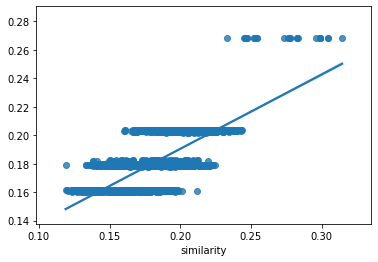

In [101]:
sns.regplot(y_test,predictions)

In [102]:
# Finally we will look at the stats

X_train_Sm = sm.add_constant(X_train)
ls=sm.OLS(y_train,X_train_Sm).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:             similarity   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     3930.
Date:                Sat, 03 Jul 2021   Prob (F-statistic):               0.00
Time:                        12:32:39   Log-Likelihood:                 69475.
No. Observations:               24882   AIC:                        -1.389e+05
Df Residuals:                   24874   BIC:                        -1.389e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

### Classical Decision Tree

- https://www.pluralsight.com/guides/non-linear-regression-trees-scikit-learn
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [ ]:
# Initialize the decision tree and fit the model
dtree = DecisionTreeRegressor(max_depth=6,min_samples_leaf=0.1,random_state=3)
dtree.fit(X_train,y_train)

# Prediction output training set
pred_train_tree = dtree.predict(X_train)
print('Tree - RMSE (train)',np.sqrt(mean_squared_error(y_train,pred_train_tree)))
print('Tree - R2 (train)',r2_score(y_train, pred_train_tree))

# Prediction output test set
pred_test_tree = dtree.predict(X_test)
print('Tree - RMSE (test)',np.sqrt(mean_squared_error(y_test,pred_test_tree)))
print('Tree - R2 (test)',r2_score(y_test, pred_test_tree))

### Random Forest Regressor

### Introduction to RF

- https://www.datacamp.com/community/tutorials/random-forests-classifier-python
- https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
- https://medium.datadriveninvestor.com/random-forest-regression-9871bc9a25eb
- https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

## Cross-Validation & tuning

- https://scikit-learn.org/stable/modules/cross_validation.html
- https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [ ]:
# Let's see what parameters we can work with when tuning the model
model_rf.get_params()

In [366]:



# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [ ]:
# Use the random grid to search for best hyperparameters

# First create the base model to tune
rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)


In [ ]:
# Initializing random forest model and fitting the training data to the model
model_rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
model_rf_random = RandomizedSearchCV(estimator=model_rf,param_distributions=random_grid,n_iter=10,cv=3,verbose=2,
                             random_state=42,n_jobs=-1)

# Fit the random search model
model_rf_random.fit(X_train,y_train)

# Find the best parameters
best_rf_random = model_rf_random.best_params_

## Run on train set with tune hyperparameters

To see whether the random search Cross-validation provided us with a better tuned model than the base model let's compare the two.

In [ ]:
def evaluate_model(model,test_features,test_labels):
    predictions = model.predict(test_features)
    print('Model Performance')
    print('Random Forest - RMSE (train)',np.sqrt(mean_squared_error(test_labels,predictions)))
    print('Random Forest - R2 (train)',r2_score(test_labels, predictions))
    print('--------------------------')
    

model_rf.fit(X_train,y_train)

base_performance = evaluate_model(base_model_rf,X_train,y_train)

best_rf_random = evaluate_model(model_rf_random,X_train,y_train)


## Finally run on test set

In [ ]:
pred_test_rf = model_rf.predict(X_test)
print('Random Forest - RMSE (test)',np.sqrt(mean_squared_error(y_test,pred_test_rf)))
print('Random Forest - R2 (test)',r2_score(y_test, pred_test_rf))

# Let's see which features are most important
# rf_feature_importance = pd.Series(model_rf_random.feature_importances_,index=features_index).sort_values(ascending=False)


In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x=rf_feature_importance,y=features_index)
sns.despine()

In [ ]:
plt.figure(figsize=(12,8))
predictions_RF = model_rf.predict(X_test)
predictions_RF
sns.regplot(y_test,predictions_RF)
sns.despine()

## Resources

- https://scikit-learn.org/stable/modules/feature_extraction.html
- https://www.analyticsvidhya.com/blog/2019/08/3-techniques-extract-features-from-image-data-machine-learning-python/

- https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/
- https://chrisalbon.com/
- https://scikit-learn.org/stable/modules/feature_extraction.html

Feature extraction could be used to get the 400x400 (or 1d = 1x160,000) matrix into the right format for a classifier.

**IMPORTANT** 

I need to make sure I delete the 2nd scan session of the adolescents otherwise I might be overfitting with within subject data.


## 5.2 ) Predicting Age of participants

In [120]:
# X predictor features 79800 1D array
connectomes_classifier = family_classifier
connectomes_classifier.shape

(79800, 168)

In [126]:
y_age = covariates['age']
y_age_final = y_age.values.reshape((168,1))
y_age_final.shape

(168, 1)

In [128]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(connectomes_classifier, y_age_final, test_size=0.3) # 70% training and 30% test

ValueError: Found input variables with inconsistent numbers of samples: [79800, 168]

### MLR - 2nd order Polynomial

**Background Info**
- see: https://developpaper.com/polynomial-regression-and-model-generalization-in-machine-learning/
- https://towardsdatascience.com/polynomial-regression-with-scikit-learn-what-you-should-know-bed9d3296f2

**ATTENTION**

Polynomial features can lead to feature explosion and with 160,000 features this is not feasable.

- We need to do some feature selection first (https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b)
- https://scikit-learn.org/stable/modules/feature_selection.html

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Initiate the MRL 
mlr_age = LinearRegression()

# FEATURE SELECTIOn (Exclude low variance features)

# Fit the model to the training's set
mlr_age.fit(X_train,y_train)

# poly PIPELINE
# degree=2
# poly_reg = make_pipeline(PolynomialFeatures(degree),LinearRegression())
# poly_reg.fit(X_train,y_train)
# poly_reg_predict = poly_reg.predict(X_test)

## LINEAR Predictor
mlr_age_ypred = mlr_age.predict(X_test)

plt.figure(figsize=(13,8))
sns.regplot(y,mlr_age_ypred,order=2,color=family_color)
sns.despine()

mlr_age_accuracy = r2_score(y_test,mlr_age_ypred)
print('MLR Age:', mlr_age_accuracy)
print('MPR Age:', poly_reg_accuracy)


## 5.2.2) Random Forest regression

In [ ]:
rfr_age = RandomForestRegressor(n_estimators=100)

rfr_age.fit(X_train,y_train)

rfr_age_pred = rfr_age.predict(X_test)

#Accuracy of prediction
rfr_age_accuracy = r2_score(y_test,rfr_age_pred)
rfr_age_accuracy

# dFC - Tutorial 

- https://dyconnmap.readthedocs.io/en/latest/
- https://github.com/makism/dyconnmap/tree/master/tutorials

In [3]:
from dyconnmap import tvfcg
from dyconnmap.fc import IPLV